# Analysis of meteorological variables

This document contains an initial correlation analysis between the variables obtained from the GFS prediction model in order to discover numerical correspondence for their association, before the feeding and building of the neural network model.

From this analysis, different strategies will be generated and the necessity of involving other atmospheric variables or calculating subproducts from these initial input variables will be evaluated.

### 1. Import of packages

In [32]:
import pandas as pd, h5py, numpy as np
from datetime import datetime, timedelta
from itertools import product

import matplotlib.pyplot as plt
import matplotlib.dates as mdate

from pvlib.location import Location
from pvlib import solarposition

### 2. Loading of retrieved meteorological data

Here, the file paths containing the post-processed forecasted data are assigned for loading one-year data.

In [33]:
fname = '../data/2020-01-01_2021-01-01_0p25_MDE.h5'
f = h5py.File(fname,'r')

The post-processed files contain basic information from the prediction model that is used in the analysis. Therefore, some parameters need to be first extracted.

Binary files with atmospheric variables are loaded into a Pandas Dataframe. 

In [34]:
fc_time = '00UTC'
dt1 = f[fc_time]['timestamp'][0].astype('datetime64[s]')
dt2 = f[fc_time]['timestamp'][-1].astype('datetime64[s]')
lat = 6.25
lon = 284.5
outres = 180

# Loading of data into Dataframe
df = pd.DataFrame()
attrs = {}
for prm in f[fc_time].keys():
    if prm == 'timestamp':
        df.index = f[fc_time][prm][:].astype('datetime64[s]')
    else:
        df[prm] = f[fc_time][prm][:]
        attrs[prm] = f[fc_time][prm].attrs['units']

### 3. Adjusting of retrieved data

For the data handling and analysis it is convinient to switch the meteorological product default names to shorter names. 

Therefore a renaming is made.

In [35]:
#new variable names for renaming
variables = {'Cloud_water_entire_atmosphere_single_layer':'total_water_clouds',
             'Downward_Long-Wave_Radp_Flux_surface_': 'ghi_lw_avg',
             'Downward_Short-Wave_Radiation_Flux_surface_':'ghi_sw_avg',
             'Planetary_Boundary_Layer_Height_surface':'PBL_height',
             'Precipitable_water_entire_atmosphere_single_layer':'total_precip_water',
             'Precipitation_rate_surface':'total_precip_rate',
             'Precipitation_rate_surface_':'precip_rate_avg',
             'Temperature_surface':'temp_air',
             'Total_cloud_cover_boundary_layer_cloud_':'boundary_clouds_avg',
             'Total_cloud_cover_convective_cloud':'convect_clouds',
             'Total_cloud_cover_entire_atmosphere_': 'total_clouds_avg'}

#renaming of variables
df = df.rename(columns=variables)
attrs = {(variables[k] if k in variables else k):v  for (k,v) in attrs.items() }

### 3.1 Correction of 6 hour average to 3 hour average

By default, some GFS model products are presented as averages between the last forecast runtime (four per day) and each forecast product (every 3 hours); meaning that the averaging may vary from 3-hours to 6-hour depending on the time a forecast is made for, and the reference time the forecast model was run.

Thus for having uniform averaging in the model variables, a recalculation for 6-hour averages to convert to 3-hour averages is required.

In [36]:
#Correction of 6hour averaging
for prm in df.columns:
    if 'avg' in prm:
        df.loc[df.index.hour % 6 == 0 ,[prm]] = (df[prm]*2)-df[prm].shift(1)

### 3.2 Clear sky model and Solar position

Analysis can be made for irradiance values or clear sky indexes. 

This is why a clear sky model is calculated as well as the solar position at each timestamp. 

In [37]:
def get_csmodel(dt1,dt2,lat,lon,outres):
    times = pd.date_range(start=dt1, end=dt2, freq='30Min', tz='UTC')
    outres = str(outres)+'Min'
    tus = Location(lat, lon-360, 'America/Bogota', 1495,'MDE') #Torre SIATA
    solpos= solarposition.get_solarposition(times,tus.latitude,tus.longitude,tus.altitude)
    cs = tus.get_clearsky(times)

    cs.index = cs.index.tz_convert('UTC').tz_localize(None)

    cs=cs.resample(outres,closed='right',label='right').mean()

    solpos=solarposition.get_solarposition(cs.index,tus.latitude,tus.longitude,tus.altitude)
    azimuth = solpos.azimuth
    zenith_ang = solpos.apparent_zenith
    zenith_ang[zenith_ang > 90] = np.nan

    return(cs.ghi,zenith_ang,azimuth)

Solar irradiance for night hours and invalid clear sky indexes are eliminated from the series and the analysis to avoid noise.

In [38]:
df['cs_ghi'],df['zenith_ang'],df['azimuth'] = get_csmodel(dt1,dt2,lat,lon,outres)
df.index = df.index.tz_localize(tz = 'UTC')
attrs['zenith_ang'] = 'deg' 
attrs['azimuth'] = 'deg' 
attrs['cs_ghi'] = '-'

# Elimination of night hours for shortwave irradiance data
df.loc[df.zenith_ang != df.zenith_ang ,['ghi_sw_avg']] = np.nan
df.loc[df.zenith_ang != df.zenith_ang ,['ghi_lw_avg']] = np.nan

#Clear sky indexes calculation
df['csidx_sw'] = df['ghi_sw_avg'] / df['cs_ghi']
df['csidx_lw'] = df['ghi_lw_avg'] / df['cs_ghi']
attrs['csidx_sw'] = '-'
attrs['csidx_lw'] = '-'

#Elimination of invalid clear sky indexes
df.loc[df.csidx_lw > 1 ,['csidx_lw']] = np.nan
df.loc[df.csidx_lw < 0 ,['csidx_lw']] = np.nan
df.loc[df.csidx_sw > 1 ,['csidx_sw']] = np.nan
df.loc[df.csidx_sw < 0 ,['csidx_sw']] = np.nan

The way data looks like after retrevied, adjusting and calculation solar parameters is:

In [39]:
df

,total_water_clouds,ghi_lw_avg,ghi_sw_avg,PBL_height,total_precip_water,total_precip_rate,precip_rate_avg,temp_air,boundary_clouds_avg,convect_clouds,total_clouds_avg,cs_ghi,zenith_ang,azimuth,csidx_sw,csidx_lw
2020-01-01 03:00:00+00:00,0.86,NaN,NaN,85.954681,31.700001,0.0002,0.000220,288.120850,43.0,48.0,100.0,0.000000,NaN,237.571882,NaN,NaN
2020-01-01 06:00:00+00:00,0.86,NaN,NaN,67.562698,31.100000,0.0005,0.000346,287.633972,81.0,45.0,100.0,0.000000,NaN,143.236847,NaN,NaN
2020-01-01 09:00:00+00:00,1.80,NaN,NaN,73.985466,31.900000,0.0014,0.000880,287.500000,92.0,31.0,100.0,0.000000,NaN,113.189423,NaN,NaN
2020-01-01 12:00:00+00:00,1.36,379.685547,0.0,91.371887,31.299999,0.0005,0.000986,287.495667,96.0,14.0,100.0,20.586603,79.928213,114.756375,0.000000,NaN
2020-01-01 15:00:00+00:00,0.36,377.000000,20.0,121.246613,29.799999,0.0001,0.000270,287.865417,91.0,28.0,100.0,552.585385,42.353472,134.719159,0.036194,0.682248
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 12:00:00+00:00,0.01,317.804108,20.0,66.889061,24.100000,0.0000,0.000010,285.530792,31.0,0.0,76.0,20.664092,79.904246,114.781833,0.967863,NaN
2020-12-31 15:00:00+00:00,0.02,316.200714,470.0,828.324158,24.100000,0.0000,0.000000,295.615387,34.0,7.0,100.0,552.664018,42.344445,134.769279,0.850426,0.572139
2020-12-31 18:00:00+00:00,0.02,377.247040,590.0,1083.211060,24.799999,0.0001,0.000100,294.976959,52.0,27.0,100.0,964.576277,32.169204,204.108724,0.611668,0.391101
2020-12-31 21:00:00+00:00,0.02,369.915863,500.0,706.621643,25.700001,0.0004,0.000230,292.785889,0.0,64.0,100.0,696.869384,64.290415,240.725559,0.717495,0.530825


### 4. Correlation analysis

The initial analysis made for the retrieved atmospheric variables consist on finding the best curve fitting for a linneal, quadratic and exponential fit, for every pair of variables.

Best fitting and calculated RMSE is presented to make a graphical analysis. 

In [40]:

#----------------------------------------------------------------
#graph configuration
graph = {'lin':{'label':'linnear fit','colors':['dodgerblue','royalblue']},
     'quad':{'label':'quadratic fit','colors':['limegreen','forestgreen']},
     'exp':{'label':'exponential fit','colors':['mediumorchid','darkmagenta']},}
#----------------------------------------------------------------

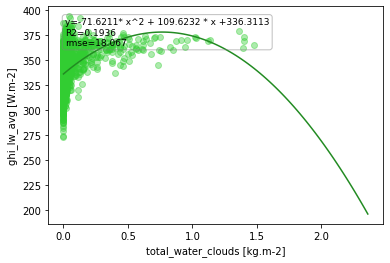

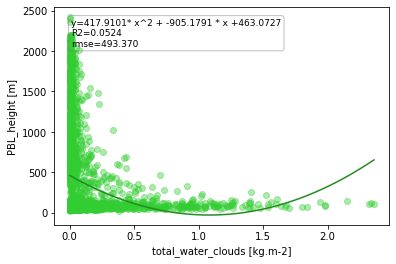

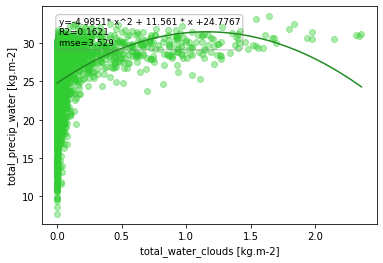

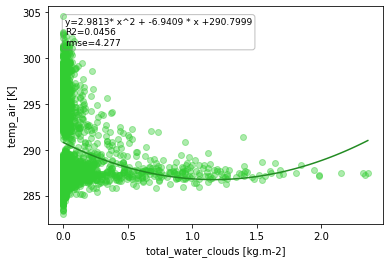

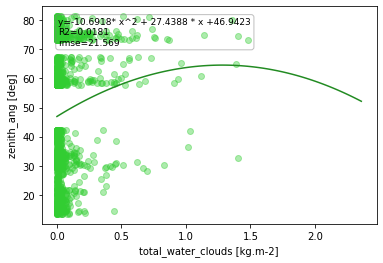

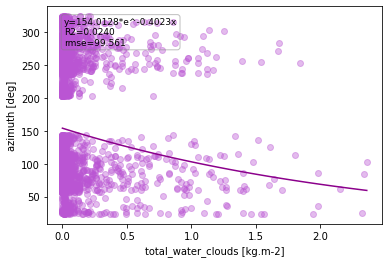

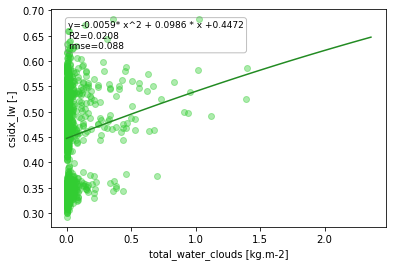

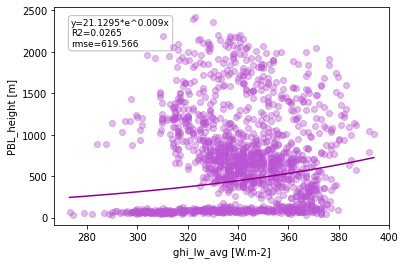

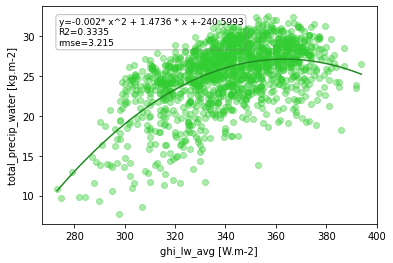

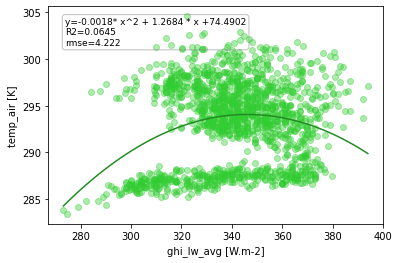

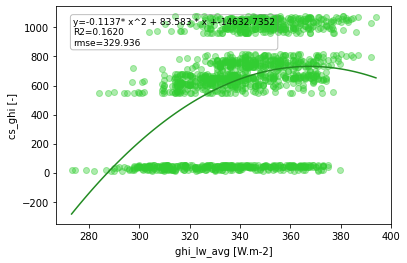

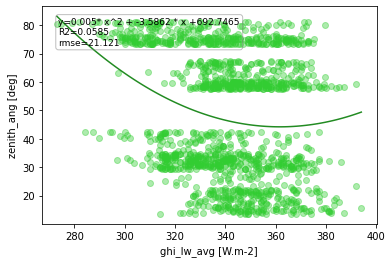

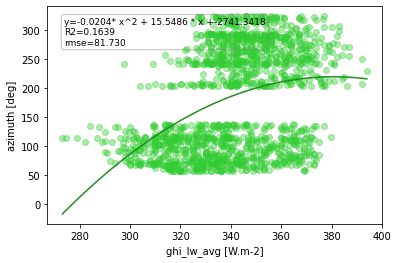

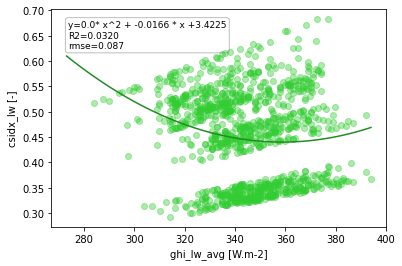

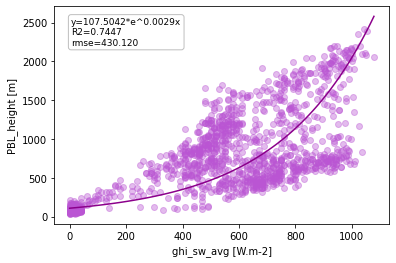

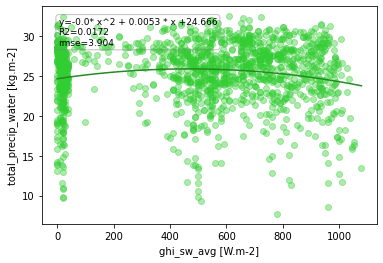

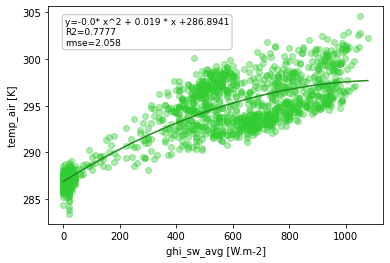

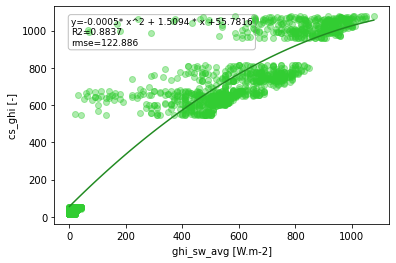

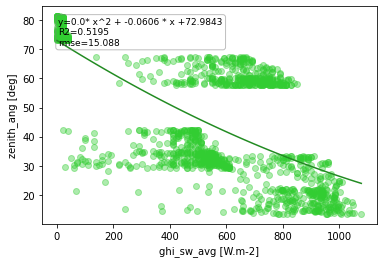

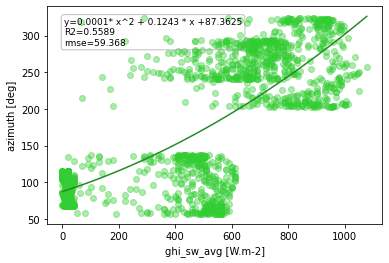

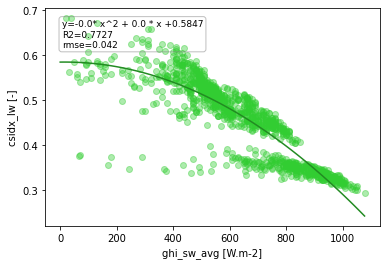

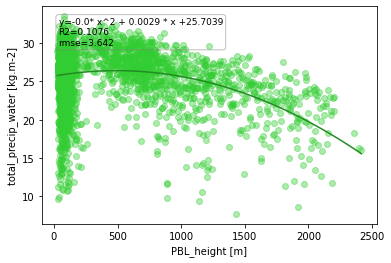

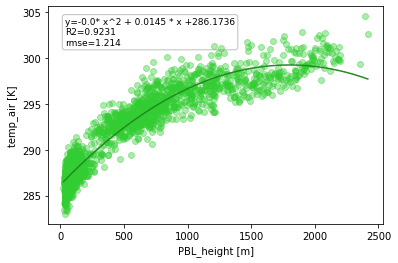

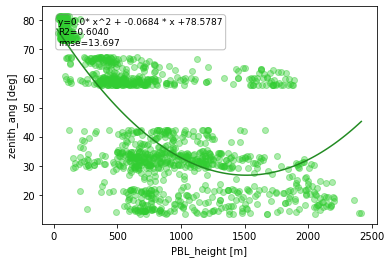

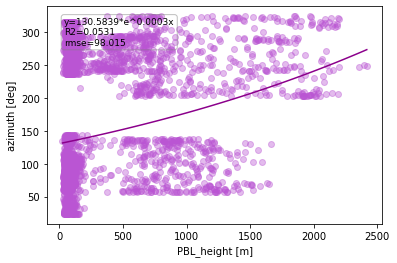

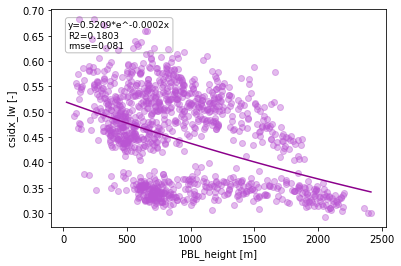

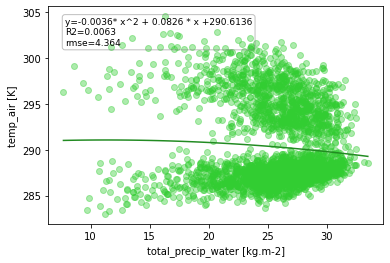

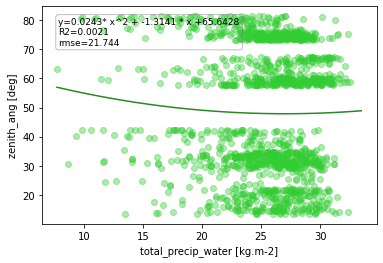

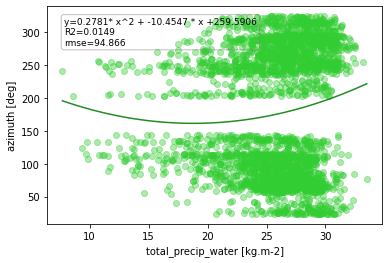

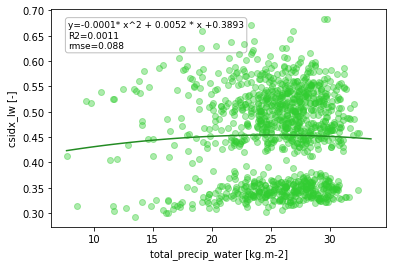

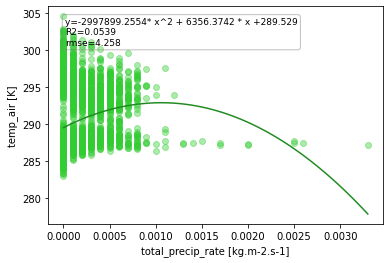

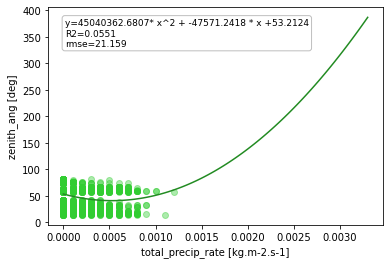

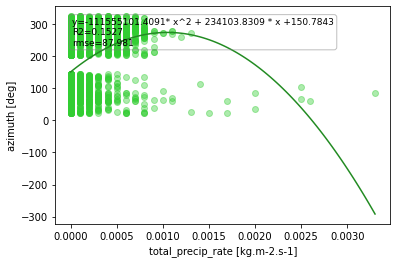

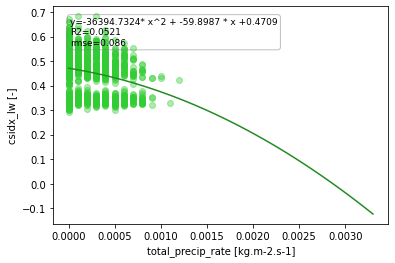

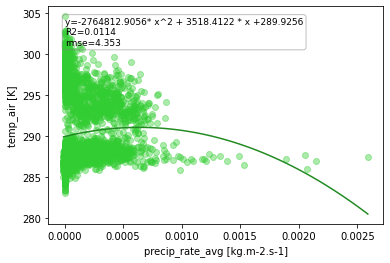

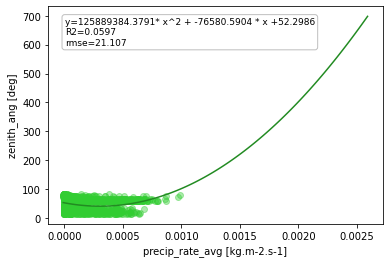

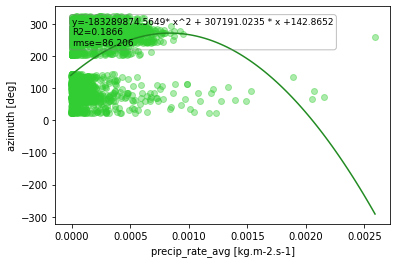

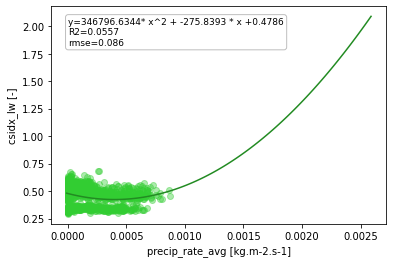

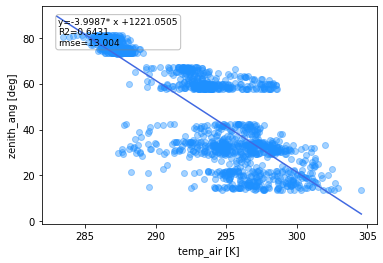

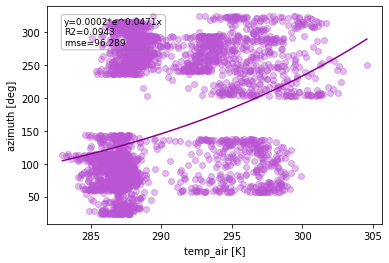

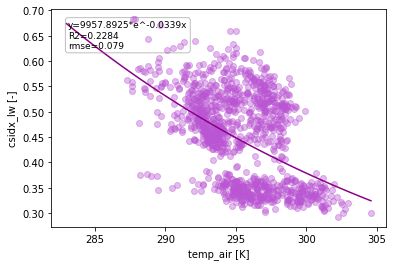

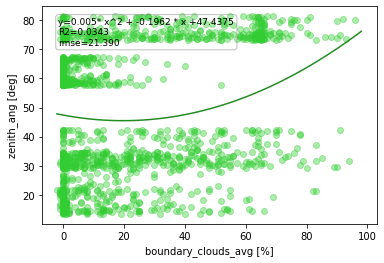

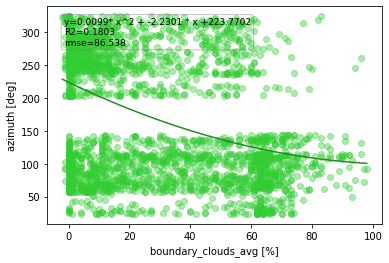

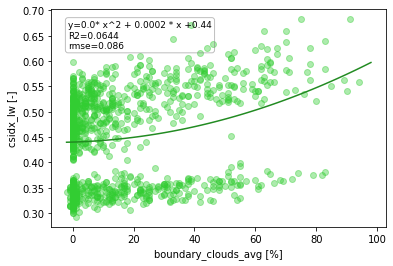

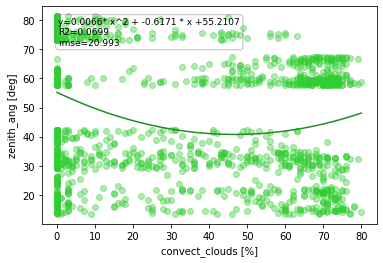

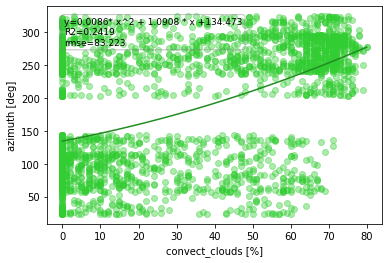

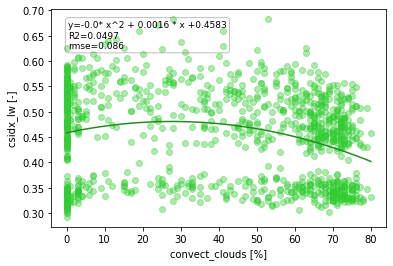

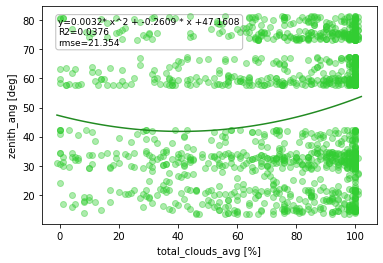

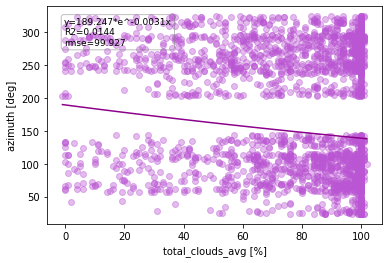

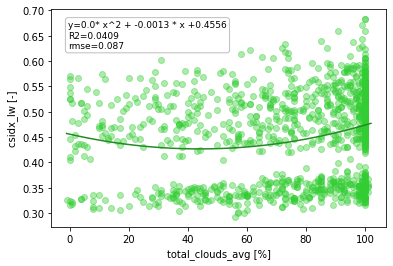

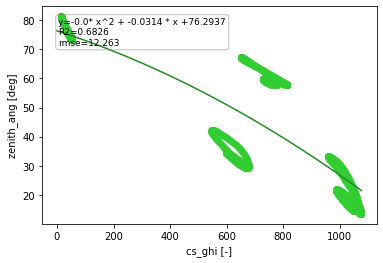

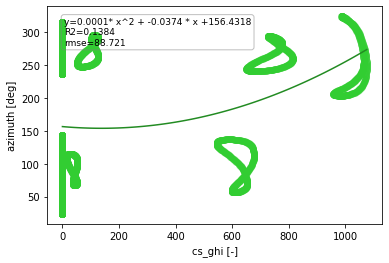

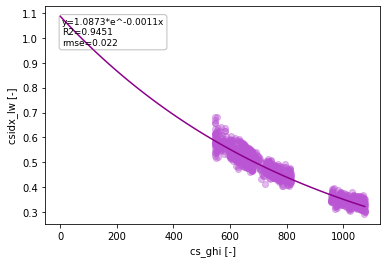

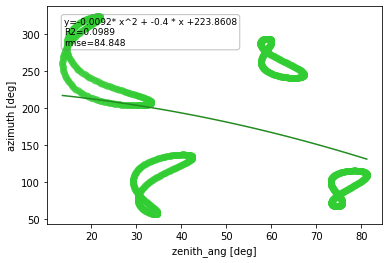

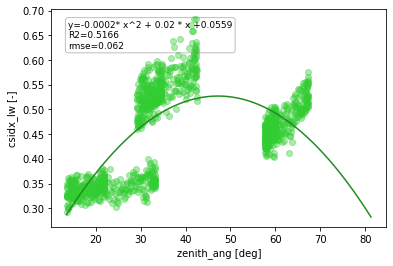

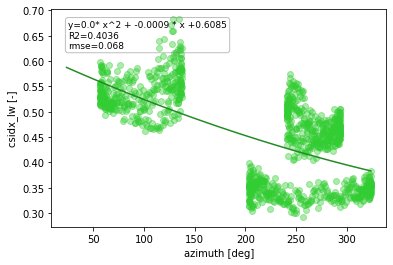

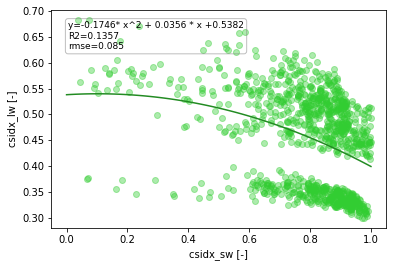

In [41]:
mtrcs = {}
import warnings
warnings.filterwarnings("ignore")
for n, (x_label, y_label) in enumerate(product(list(df.columns), list(df.columns))):
    if '{}_vs_{}'.format(x_label,y_label) and '{}_vs_{}'.format(
        y_label,x_label) not in mtrcs.keys() and x_label != y_label:
        key = '{}_vs_{}'.format(x_label,y_label)
        mtrcs[key] = {}
        # Correlation between all forecasted parameters
        x = df[x_label].to_numpy()
        y = df[y_label].to_numpy()

        idx = np.isfinite(x) & np.isfinite(y)
        pts= np.linspace(np.nanmin(x),np.nanmax(x),100)


        # Lineal correlation
        lin_fit = np.polyfit(x[idx], y[idx], 1)
        lin_vals = x[idx]*lin_fit[0]+lin_fit[1]
        lin_pts = pts*lin_fit[0]+lin_fit[1]


        correlation_matrix = np.corrcoef(y[idx], lin_vals)
        correlation_xy = correlation_matrix[0,1]
        ei = lin_vals-y[idx]
        lin_rmse = np.sqrt(np.sum(ei**2))/np.sqrt(len(y[idx]))

        mtrcs[key]['eq_lin'] = 'y={}* x +{}'.format(np.round(lin_fit[0],4),np.round(
            lin_fit[1],4))
        mtrcs[key]['R2_lin'] = correlation_xy**2
        mtrcs[key]['rmse_lin'] = lin_rmse

        # Cuadratic correlation
        quad_fit = np.polyfit(x[idx], y[idx], 2)
        quad_vals = quad_fit[0] * np.square(x[idx]) + quad_fit[1] * x[idx] + quad_fit[2]
        quad_pts = quad_fit[0] * np.square(pts) + quad_fit[1] * pts  + quad_fit[2]

        correlation_matrix = np.corrcoef(y[idx], quad_vals)
        correlation_xy = correlation_matrix[0,1]
        ei = quad_vals-y[idx]
        quad_rmse = np.sqrt(np.sum(ei**2))/np.sqrt(len(y[idx]))

        mtrcs[key]['eq_quad'] = 'y={}* x^2 + {} * x +{}'.format(
            np.round(quad_fit[0],4),np.round(quad_fit[1],4),np.round(quad_fit[2],4))
        mtrcs[key]['R2_quad'] = correlation_xy**2
        mtrcs[key]['rmse_quad'] = quad_rmse

        # exponential correlation
        exp_fit = np.polyfit(x[idx], np.log(y[idx]), 1)
        exp_vals = np.exp(exp_fit[1]) * np.exp(1)**((exp_fit[0]*x[idx]))
        exp_pts = np.exp(exp_fit[1]) * np.exp(1)**(exp_fit[0]*pts)

        correlation_matrix = np.corrcoef(np.log(y[idx]), np.log(exp_vals))
        correlation_xy = correlation_matrix[0,1]
        ei = exp_vals-y[idx]
        exp_rmse = np.sqrt(np.sum(ei**2))/np.sqrt(len(y[idx]))

        mtrcs[key]['eq_exp']='y={}*e^{}x'.format(np.round(np.exp(exp_fit[1]),4),
                            np.round(exp_fit[0],4))
        mtrcs[key]['R2_exp'] = correlation_xy**2
        mtrcs[key]['rmse_exp'] = exp_rmse

        for subkey, value in mtrcs[key].items():
            if 'R2' in subkey and value == np.max([mtrcs[key]['R2_lin'],
                                                   mtrcs[key]['R2_quad'],
                                                   mtrcs[key]['R2_exp']]):
                bst = subkey.split('R2_')[1]

                ax = plt.subplot()
                ax.scatter(x[idx],y[idx], alpha=.4,color =graph[bst]['colors'][0])
                ax.plot(pts ,locals()[bst+'_pts'],label =graph[bst]['label'][0] ,
                        color = graph[bst]['colors'][1])
                textstr = '\n'.join((r'{}'.format(mtrcs[key]['eq_'+bst]),
                r'R2=%.4f' % (mtrcs[key]['R2_'+bst], ),
                r'rmse=%.3f' % (mtrcs[key]['rmse_'+bst], )))
                bbox=dict(boxstyle="round", fc="none", ec="gray",alpha=0.5)
                ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=9,
                        verticalalignment='top', bbox=bbox)
                ax.set_xlabel(x_label+' [{}]'.format(attrs[x_label]))
                ax.set_ylabel(y_label+' [{}]'.format(attrs[y_label]))
                plt.show()